<a href="https://colab.research.google.com/github/sandushiw98/Early-Detection-of-Dysgraphia-in-Sinhala-Speaking-Children-Using-Multi-Modal-Machine-Learning/blob/main/Dysgraphia_Handwriting_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Labeling the Handwriting Data

In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the paths to your image folders
dysgraphic_folder = '/content/drive/MyDrive/Research_Dysgraphia/Child_ID with Preprocessed Dysgraphic Words'
non_dysgraphic_folder = '/content/drive/MyDrive/Research_Dysgraphia/preprocessed_Non_Dysgraphic_Letters'

def get_image_paths_labels_and_ids(folder_path, label):
    image_paths = []
    labels = []
    handwriting_ids = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".gif")):
            image_paths.append(os.path.join(folder_path, filename))
            labels.append(label)
            handwriting_id = os.path.splitext(filename)[0]  # Extract the filename without the extension
            handwriting_ids.append(handwriting_id)
            print(f"Processed filename: {filename} -> Handwriting ID: {handwriting_id}")  # Debugging print statement
    return image_paths, labels, handwriting_ids

# Get dysgraphic image paths, labels, and handwriting IDs
dysgraphic_image_paths, dysgraphic_labels, dysgraphic_handwriting_ids = get_image_paths_labels_and_ids(
    dysgraphic_folder, label=1)

# Get non-dysgraphic image paths, labels, and handwriting IDs
non_dysgraphic_image_paths, non_dysgraphic_labels, non_dysgraphic_handwriting_ids = get_image_paths_labels_and_ids(
    non_dysgraphic_folder, label=0)

# Combine the paths, labels, and handwriting IDs
image_paths = dysgraphic_image_paths + non_dysgraphic_image_paths
labels = dysgraphic_labels + non_dysgraphic_labels
handwriting_ids = dysgraphic_handwriting_ids + non_dysgraphic_handwriting_ids

# Create a DataFrame to store the image paths, labels, and handwriting IDs
data = {'Image_Path': image_paths, 'Label': labels, 'Handwriting_ID': handwriting_ids}
df = pd.DataFrame(data)

# Shuffle the DataFrame (optional but recommended)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into training and testing sets (80% training, 20% testing)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Label'])

# Save the training set to a CSV file
train_csv_path = '/content/drive/MyDrive/Research_Dysgraphia/training_dataset.csv'
train_df.to_csv(train_csv_path, index=False)

# Save the testing set to a CSV file
test_csv_path = '/content/drive/MyDrive/Research_Dysgraphia/testing_dataset.csv'
test_df.to_csv(test_csv_path, index=False)

print(f"Training dataset saved to {train_csv_path}")
print(f"Testing dataset saved to {test_csv_path}")


Processed filename: DH_1_1.png -> Handwriting ID: DH_1_1
Processed filename: DH_1_2.png -> Handwriting ID: DH_1_2
Processed filename: DH_1_3.png -> Handwriting ID: DH_1_3
Processed filename: DH_2_1.png -> Handwriting ID: DH_2_1
Processed filename: DH_2_2.png -> Handwriting ID: DH_2_2
Processed filename: DH_3_1.png -> Handwriting ID: DH_3_1
Processed filename: DH_3_2.png -> Handwriting ID: DH_3_2
Processed filename: DH_3_4.png -> Handwriting ID: DH_3_4
Processed filename: DH_4_1.png -> Handwriting ID: DH_4_1
Processed filename: DH_5_1.png -> Handwriting ID: DH_5_1
Processed filename: DH_6_1.png -> Handwriting ID: DH_6_1
Processed filename: DH_7_1.png -> Handwriting ID: DH_7_1
Processed filename: DH_7_2.png -> Handwriting ID: DH_7_2
Processed filename: DH_7_3.png -> Handwriting ID: DH_7_3
Processed filename: DH_8_1.png -> Handwriting ID: DH_8_1
Processed filename: DH_9_1.png -> Handwriting ID: DH_9_1
Processed filename: DH_10_1.png.png -> Handwriting ID: DH_10_1.png
Processed filename: D

# 1ST

# Train the model with CNN


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import os

# Load the CSV file containing image paths and labels
data = pd.read_csv('/content/drive/MyDrive/Research_Dysgraphia/training_dataset.csv')

# Extract image paths and labels
image_paths = data['Image_Path'].values
labels = data['Label'].values

# Preprocess labels using one-hot encoding
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# Function to load and preprocess images
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array / 255.0

# Create data generators for images
images = np.vstack([load_and_preprocess_image(img_path) for img_path in image_paths])

# Perform 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_val_labels = []
all_val_preds = []

for train_index, val_index in kf.split(images):
    print(f"Training fold {fold}...")
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]

    # Load pre-trained VGG16 model + higher level layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = False  # Freeze the base model

    # Build the model on top of VGG16
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(1, activation='sigmoid', dtype='float32')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model with a weighted loss function to handle class imbalance
    class_weights = {0: 1.0, 1: 3.0}
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Train the model with early stopping and learning rate scheduler
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

    history = model.fit(
        train_images, train_labels,
        validation_data=(val_images, val_labels),
        epochs=150,
        batch_size=16,
        verbose=1,
        class_weight=class_weights,
        callbacks=[early_stopping, lr_scheduler]
    )

    # Save the model for the current fold
    model.save(f'/content/drive/MyDrive/Research_Dysgraphia/New_VGG16_model_fold_{fold}.h5')

    # Evaluate the model on the validation set
    val_preds = model.predict(val_images)
    val_preds_binary = (val_preds > 0.5).astype(int)

    # Calculate metrics for the current fold
    accuracy = accuracy_score(val_labels, val_preds_binary)
    precision = precision_score(val_labels, val_preds_binary)
    recall = recall_score(val_labels, val_preds_binary)
    f1 = f1_score(val_labels, val_preds_binary)

    print(f"Fold {fold} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Store validation labels and predictions for overall evaluation if this is the last fold
    if fold == 5:
        print("\nClassification Report for Fold 5:")
        print(classification_report(val_labels, val_preds_binary))

    all_val_labels.extend(val_labels)
    all_val_preds.extend(val_preds_binary)

    fold += 1

# Final classification report and metrics after all folds
print("\nFinal Classification Report:")
print(classification_report(all_val_labels, all_val_preds))

# Save the final model
model.save('/content/drive/MyDrive/Research_Dysgraphia/New_VGG16_final_model.h5')


Training fold 1...
Epoch 1/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 293ms/step - accuracy: 0.4918 - loss: 4.2391 - val_accuracy: 0.8361 - val_loss: 3.6246 - learning_rate: 5.0000e-05
Epoch 2/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5412 - loss: 4.3154 - val_accuracy: 0.5902 - val_loss: 3.6212 - learning_rate: 5.0000e-05
Epoch 3/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5476 - loss: 4.1765 - val_accuracy: 0.1967 - val_loss: 3.6487 - learning_rate: 5.0000e-05
Epoch 4/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5018 - loss: 4.1947 - val_accuracy: 0.1967 - val_loss: 3.6646 - learning_rate: 5.0000e-05
Epoch 5/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5567 - loss: 4.0573 - val_accuracy: 0.1967 - val_loss: 3.6698 - learning_rate: 5.0000e-05
Epoch 6/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6579 - loss: 3.7644 - val_accuracy: 0.1967 - val_loss: 3.6599 - learning_rate: 5.0000e-05
Epoch 7/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 3

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
Fold 1 - Accuracy: 0.9180, Precision: 0.7692, Recall: 0.8333, F1 Score: 0.8000
Training fold 2...
Epoch 1/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 308ms/step - accuracy: 0.4160 - loss: 4.6791 - val_accuracy: 0.1803 - val_loss: 3.6577 - learning_rate: 5.0000e-05
Epoch 2/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4704 - loss: 4.3155 - val_accuracy: 0.1803 - val_loss: 3.6947 - learning_rate: 5.0000e-05
Epoch 3/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4393 - loss: 4.2699 - val_accuracy: 0.1803 - val_loss: 3.7243 - learning_rate: 5.0000e-05
Epoch 4/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5689 - loss: 3.9935 - val_accuracy: 0.1803 - val_loss: 3.7517 - learning_rate: 5.0000e-05
Epoch 5/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5568 - loss: 3.9352 - val_accuracy: 0.1803 - val_loss: 3.7738 - learning_rate: 5.0000e-05
Epoch 6/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4695 - loss: 4.

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
Fold 2 - Accuracy: 0.1803, Precision: 0.1176, Recall: 0.5455, F1 Score: 0.1935
Training fold 3...
Epoch 1/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 389ms/step - accuracy: 0.5173 - loss: 4.1624 - val_accuracy: 0.6066 - val_loss: 3.6486 - learning_rate: 5.0000e-05
Epoch 2/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5287 - loss: 4.2949 - val_accuracy: 0.4426 - val_loss: 3.6287 - learning_rate: 5.0000e-05
Epoch 3/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5420 - loss: 4.1368 - val_accuracy: 0.3115 - val_loss: 3.6238 - learning_rate: 5.0000e-05
Epoch 4/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5942 - loss: 3.9162 - val_accuracy: 0.3115 - val_loss: 3.5984 - learning_rate: 5.0000e-05
Epoch 5/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6098 - loss: 3.8079 - val_accuracy: 0.3770 - val_loss: 3.5642 - learning_rate: 5.0000e-05
Epoch 6/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5780 - loss: 3.

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 485ms/step
Fold 3 - Accuracy: 0.9344, Precision: 0.6923, Recall: 1.0000, F1 Score: 0.8182
Training fold 4...
Epoch 1/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 311ms/step - accuracy: 0.5082 - loss: 4.4055 - val_accuracy: 0.8167 - val_loss: 3.5710 - learning_rate: 5.0000e-05
Epoch 2/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5160 - loss: 4.2553 - val_accuracy: 0.8167 - val_loss: 3.4869 - learning_rate: 5.0000e-05
Epoch 3/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5357 - loss: 4.1296 - val_accuracy: 0.8167 - val_loss: 3.4286 - learning_rate: 5.0000e-05
Epoch 4/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6154 - loss: 4.0347 - val_accuracy: 0.8167 - val_loss: 3.3765 - learning_rate: 5.0000e-05
Epoch 5/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5570 - loss: 3.9911 - val_accuracy: 0.8167 - val_loss: 3.3372 - learning_rate: 5.0000e-05
Epoch 6/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6791 - loss: 3.

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
Fold 4 - Accuracy: 0.9667, Precision: 1.0000, Recall: 0.8182, F1 Score: 0.9000
Training fold 5...
Epoch 1/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.5953 - loss: 4.0620 - val_accuracy: 0.2500 - val_loss: 3.7414 - learning_rate: 5.0000e-05
Epoch 2/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6261 - loss: 4.0618 - val_accuracy: 0.6500 - val_loss: 3.5910 - learning_rate: 5.0000e-05
Epoch 3/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5968 - loss: 4.0206 - val_accuracy: 0.7500 - val_loss: 3.4958 - learning_rate: 5.0000e-05
Epoch 4/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5803 - loss: 4.0007 - val_accuracy: 0.7500 - val_loss: 3.4235 - learning_rate: 5.0000e-05
Epoch 5/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5908 - loss: 3.8878 - val_accuracy: 0.7500 - val_loss: 3.3734 - learning_rate: 5.0000e-05
Epoch 6/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6162 - loss: 3.

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step


Fold 5 - Accuracy: 0.9000, Precision: 0.8000, Recall: 0.8000, F1 Score: 0.8000

Classification Report for Fold 5:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        45
           1       0.80      0.80      0.80        15

    accuracy                           0.90        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.90      0.90      0.90        60


Final Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.78      0.85       245
           1       0.46      0.79      0.58        58

    accuracy                           0.78       303
   macro avg       0.70      0.78      0.71       303
weighted avg       0.85      0.78      0.80       303



In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import os

# Load the CSV file containing image paths and labels
data = pd.read_csv('/content/drive/MyDrive/Research_Dysgraphia/training_dataset.csv')

# Extract image paths and labels
image_paths = data['Image_Path'].values
labels = data['Label'].values

# Preprocess labels using one-hot encoding
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# Function to load and preprocess images
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array / 255.0

# Create data generators for images
images = np.vstack([load_and_preprocess_image(img_path) for img_path in image_paths])

# Perform 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_val_labels = []
all_val_preds = []

for train_index, val_index in kf.split(images):
    print(f"Training fold {fold}...")
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]

    # Load pre-trained VGG16 model + higher level layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = False  # Freeze the base model

    # Build the model on top of VGG16
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(1, activation='sigmoid', dtype='float32')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model with a weighted loss function to handle class imbalance
    class_weights = {0: 1.0, 1: 3.0}
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Train the model with early stopping and learning rate scheduler
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

    # history = model.fit(
    #     train_images, train_labels,
    #     validation_data=(val_images, val_labels),
    #     epochs=150,
    #     batch_size=16,
    #     verbose=1,
    #     class_weight=class_weights,
    #     callbacks=[early_stopping, lr_scheduler]
    # )

    #Save the model for the current fold
    # model.save(f'/content/drive/MyDrive/Research_Dysgraphia/VGG16_model_fold_{fold}.h5')
    model = tf.keras.models.load_model(f'/content/drive/MyDrive/Research_Dysgraphia/VGG16_model_fold_{fold}.h5')

    # Evaluate the model on the validation set
    val_preds = model.predict(val_images)
    val_preds_binary = (val_preds > 0.5).astype(int)

    # Calculate metrics for the current fold
    accuracy = accuracy_score(val_labels, val_preds_binary)
    precision = precision_score(val_labels, val_preds_binary)
    recall = recall_score(val_labels, val_preds_binary)
    f1 = f1_score(val_labels, val_preds_binary)

    print(f"Fold {fold} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Store validation labels and predictions for overall evaluation
    all_val_labels.extend(val_labels)
    all_val_preds.extend(val_preds_binary)

    fold += 1

# Final classification report and metrics after all folds
print("\nFinal Classification Report:")
print(classification_report(all_val_labels, all_val_preds))
print(all_val_labels)
print(all_val_preds)

# Save the final model
# model.save('/content/drive/MyDrive/Research_Dysgraphia/VGG16_final_model.h5')


Training fold 1...


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
Fold 1 - Accuracy: 0.9836, Precision: 1.0000, Recall: 0.9167, F1 Score: 0.9565
Training fold 2...


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 - Accuracy: 0.8197, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Training fold 3...


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
Fold 3 - Accuracy: 0.9344, Precision: 0.6923, Recall: 1.0000, F1 Score: 0.8182
Training fold 4...


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
Fold 4 - Accuracy: 0.9167, Precision: 0.7143, Recall: 0.9091, F1 Score: 0.8000
Training fold 5...


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
Fold 5 - Accuracy: 0.9167, Precision: 0.8125, Recall: 0.8667, F1 Score: 0.8387

Final Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       245
           1       0.80      0.74      0.77        58

    accuracy                           0.91       303
   macro avg       0.87      0.85      0.86       303
weighted avg       0.91      0.91      0.91       303

[array([0]), array([0]), array([1]), array([1]), array([1]), array([0]), array([1]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([1]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([1]), array([0]), array([0]), array([0]), array([0]), array([0]), array([1]), array([1

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

# Parameters
image_size = (128, 128)
batch_size = 8

# Load the testing dataset
testing_dataset_path = '/content/drive/MyDrive/Research_Dysgraphia/testing_dataset.csv'
test_df = pd.read_csv(testing_dataset_path)
test_df['Label'] = test_df['Label'].astype(str)

# Prepare the testing data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Image_Path",
    y_col="Label",
    target_size=image_size,
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False
)

# Load the best model
best_model_path = f'/content/drive/MyDrive/Research_Dysgraphia/New_VGG16_model_fold_4.h5'
model = tf.keras.models.load_model(best_model_path)

# Evaluate the model on the testing dataset
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Testing Loss: {test_loss}")
print(f"Testing Accuracy: {test_accuracy}")

# Generate predictions
predictions = model.predict(test_generator)
predicted_labels = (predictions >= 0.5).astype(int).reshape(-1)

# True labels
true_labels = test_generator.classes

# Confusion Matrix and Classification Report
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

target_names = ['Non-Dysgraphic', 'Dysgraphic']
report = classification_report(true_labels, predicted_labels, target_names=target_names)
print("Classification Report:")
print(report)


Found 76 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.9566 - loss: 1.7299
Testing Loss: 1.7490336894989014
Testing Accuracy: 0.9473684430122375
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
Confusion Matrix:
[[59  2]
 [ 2 13]]
Classification Report:
                precision    recall  f1-score   support

Non-Dysgraphic       0.97      0.97      0.97        61
    Dysgraphic       0.87      0.87      0.87        15

      accuracy                           0.95        76
     macro avg       0.92      0.92      0.92        76
  weighted avg       0.95      0.95      0.95        76



# delete

In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import os

# Load the CSV file containing image paths and labels
data = pd.read_csv('/content/drive/MyDrive/Research_Dysgraphia/training_dataset.csv')

# Extract image paths and labels
image_paths = data['Image_Path'].values
labels = data['Label'].values

# Preprocess labels using one-hot encoding
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# Function to load and preprocess images
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array / 255.0

# Create data generators for images
images = np.vstack([load_and_preprocess_image(img_path) for img_path in image_paths])

# Perform 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_val_labels = []
all_val_preds = []

for train_index, val_index in kf.split(images):
    print(f"Training fold {fold}...")
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]

    # Load pre-trained VGG16 model + higher level layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = False  # Freeze the base model

    # Build the model on top of VGG16
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(1, activation='sigmoid', dtype='float32')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model with a weighted loss function to handle class imbalance
    class_weights = {0: 1.0, 1: 3.0}
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Train the model with early stopping and learning rate scheduler
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

    history = model.fit(
        train_images, train_labels,
        validation_data=(val_images, val_labels),
        epochs=150,
        batch_size=16,
        verbose=1,
        class_weight=class_weights,
        callbacks=[early_stopping, lr_scheduler]
    )

    #Save the model for the current fold
    model.save(f'/content/drive/MyDrive/Research_Dysgraphia/VGG16_model123_fold_{fold}.h5')
    model = tf.keras.models.load_model(f'/content/drive/MyDrive/Research_Dysgraphia/VGG16_model123_fold_{fold}.h5')

    # Evaluate the model on the validation set
    val_preds = model.predict(val_images)
    val_preds_binary = (val_preds > 0.5).astype(int)

    # Calculate metrics for the current fold
    accuracy = accuracy_score(val_labels, val_preds_binary)
    precision = precision_score(val_labels, val_preds_binary)
    recall = recall_score(val_labels, val_preds_binary)
    f1 = f1_score(val_labels, val_preds_binary)

    print(f"Fold {fold} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Store validation labels and predictions for overall evaluation
    all_val_labels.extend(val_labels)
    all_val_preds.extend(val_preds_binary)

    fold += 1

# Final classification report and metrics after all folds
print("\nFinal Classification Report:")
print(classification_report(all_val_labels, all_val_preds))
print(all_val_labels)
print(all_val_preds)

#Save the final model
model.save('/content/drive/MyDrive/Research_Dysgraphia/VGG16_final_model123.h5')


Training fold 1...
Epoch 1/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 377ms/step - accuracy: 0.4788 - loss: 4.3799 - val_accuracy: 0.1967 - val_loss: 3.7239 - learning_rate: 5.0000e-05
Epoch 2/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5747 - loss: 4.0134 - val_accuracy: 0.6230 - val_loss: 3.6113 - learning_rate: 5.0000e-05
Epoch 3/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6062 - loss: 3.8928 - val_accuracy: 0.8197 - val_loss: 3.5182 - learning_rate: 5.0000e-05
Epoch 4/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5758 - loss: 3.9186 - val_accuracy: 0.8033 - val_loss: 3.4342 - learning_rate: 5.0000e-05
Epoch 5/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6515 - loss: 3.8729 - val_accuracy: 0.8033 - val_loss: 3.3639 - learning_rate: 5.0000e-05
Epoch 6/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6420 - loss: 3.8071 - val_accuracy: 0.8033 - val_loss: 3.3067 - learning_rate: 5.0000e-05
Epoch 7/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 3

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 488ms/step
Fold 1 - Accuracy: 0.9836, Precision: 1.0000, Recall: 0.9167, F1 Score: 0.9565
Training fold 2...
Epoch 1/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 322ms/step - accuracy: 0.5706 - loss: 4.1826 - val_accuracy: 0.1803 - val_loss: 3.6751 - learning_rate: 5.0000e-05
Epoch 2/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.4801 - loss: 4.1020 - val_accuracy: 0.5410 - val_loss: 3.6107 - learning_rate: 5.0000e-05
Epoch 3/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5519 - loss: 4.0397 - val_accuracy: 0.8361 - val_loss: 3.5461 - learning_rate: 5.0000e-05
Epoch 4/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5252 - loss: 3.9032 - val_accuracy: 0.8197 - val_loss: 3.4850 - learning_rate: 5.0000e-05
Epoch 5/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5864 - loss: 3.8538 - val_accuracy: 0.8197 - val_loss: 3.4211 - learning_rate: 5.0000e-05
Epoch 6/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5547 - loss: 3.

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 485ms/step
Fold 2 - Accuracy: 0.9508, Precision: 0.7857, Recall: 1.0000, F1 Score: 0.8800
Training fold 3...
Epoch 1/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 299ms/step - accuracy: 0.4628 - loss: 4.6459 - val_accuracy: 0.8525 - val_loss: 3.4575 - learning_rate: 5.0000e-05
Epoch 2/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4267 - loss: 4.4339 - val_accuracy: 0.8525 - val_loss: 3.4927 - learning_rate: 5.0000e-05
Epoch 3/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5159 - loss: 4.1691 - val_accuracy: 0.9180 - val_loss: 3.5508 - learning_rate: 5.0000e-05
Epoch 4/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5075 - loss: 4.0124 - val_accuracy: 0.1475 - val_loss: 3.5982 - learning_rate: 5.0000e-05
Epoch 5/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5085 - loss: 4.2650 - val_accuracy: 0.1475 - val_loss: 3.6492 - learning_rate: 5.0000e-05
Epoch 6/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4457 - loss: 4.

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 488ms/step
Fold 3 - Accuracy: 0.8525, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Training fold 4...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 787ms/step - accuracy: 0.4986 - loss: 4.3938 - val_accuracy: 0.8167 - val_loss: 3.5202 - learning_rate: 5.0000e-05
Epoch 2/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4739 - loss: 4.1245 - val_accuracy: 0.8167 - val_loss: 3.4908 - learning_rate: 5.0000e-05
Epoch 3/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4826 - loss: 4.1379 - val_accuracy: 0.8167 - val_loss: 3.4669 - learning_rate: 5.0000e-05
Epoch 4/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4784 - loss: 4.1946 - val_accuracy: 0.8167 - val_loss: 3.4468 - learning_rate: 5.0000e-05
Epoch 5/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5108 - loss: 4.0050 - val_accuracy: 0.8167 - val_loss: 3.4236 - learning_rate: 5.0000e-05
Epoch 6/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5163 - loss: 3.8772 - val_accuracy: 0.8167 - val_loss: 3.4081 - learning_rate: 5.0000e-05
Epoch 7/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
Fold 4 - Accuracy: 0.9500, Precision: 0.7857, Recall: 1.0000, F1 Score: 0.8800
Training fold 5...
Epoch 1/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 389ms/step - accuracy: 0.4546 - loss: 4.5734 - val_accuracy: 0.3333 - val_loss: 3.6512 - learning_rate: 5.0000e-05
Epoch 2/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4856 - loss: 4.2138 - val_accuracy: 0.2500 - val_loss: 3.6810 - learning_rate: 5.0000e-05
Epoch 3/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5276 - loss: 4.1715 - val_accuracy: 0.2500 - val_loss: 3.7110 - learning_rate: 5.0000e-05
Epoch 4/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5364 - loss: 4.3363 - val_accuracy: 0.2500 - val_loss: 3.7361 - learning_rate: 5.0000e-05
Epoch 5/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5225 - loss: 4.0031 - val_accuracy: 0.2500 - val_loss: 3.7210 - learning_rate: 5.0000e-05
Epoch 6/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5528 - loss: 4.

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


Fold 5 - Accuracy: 0.8500, Precision: 0.6250, Recall: 1.0000, F1 Score: 0.7692

Final Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       245
           1       0.76      0.83      0.79        58

    accuracy                           0.92       303
   macro avg       0.86      0.88      0.87       303
weighted avg       0.92      0.92      0.92       303

[array([0]), array([0]), array([1]), array([1]), array([1]), array([0]), array([1]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([1]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([1]), array([0]), array([0]), array([0]), array([0]), array([0]), array([1]), array([1]), array([0]), array([0]), array([0]),

In [17]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

# Parameters
image_size = (128, 128)
batch_size = 8

# Load the testing dataset
testing_dataset_path = '/content/drive/MyDrive/Research_Dysgraphia/testing_dataset.csv'
test_df = pd.read_csv(testing_dataset_path)
test_df['Label'] = test_df['Label'].astype(str)

# Prepare the testing data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Image_Path",
    y_col="Label",
    target_size=image_size,
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False
)

# Load the best model
best_model_path = f'/content/drive/MyDrive/Research_Dysgraphia/VGG16_model123_fold_2.h5'
model = tf.keras.models.load_model(best_model_path)

# Evaluate the model on the testing dataset
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Testing Loss: {test_loss}")
print(f"Testing Accuracy: {test_accuracy}")

# Generate predictions
predictions = model.predict(test_generator)
predicted_labels = (predictions >= 0.5).astype(int).reshape(-1)

# True labels
true_labels = test_generator.classes

# Confusion Matrix and Classification Report
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

target_names = ['Non-Dysgraphic', 'Dysgraphic']
report = classification_report(true_labels, predicted_labels, target_names=target_names)
print("Classification Report:")
print(report)


Found 76 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.9811 - loss: 1.6700
Testing Loss: 1.6940048933029175
Testing Accuracy: 0.9605262875556946
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
Confusion Matrix:
[[59  2]
 [ 1 14]]
Classification Report:
                precision    recall  f1-score   support

Non-Dysgraphic       0.98      0.97      0.98        61
    Dysgraphic       0.88      0.93      0.90        15

      accuracy                           0.96        76
     macro avg       0.93      0.95      0.94        76
  weighted avg       0.96      0.96      0.96        76



In [ ]:
import pandas as pd

# Adding predictions to the dataframe
test_df['Predicted_Label'] = predicted_labels

# Save the dataframe to CSV
predictions_csv_path = '/content/drive/MyDrive/Research_Dysgraphia/predictions_with_labels.csv'
test_df.to_csv(predictions_csv_path, index=False)

print(f"Predictions saved to {predictions_csv_path}")


Predictions saved to /content/drive/MyDrive/Research_Dysgraphia/predictions_with_labels.csv


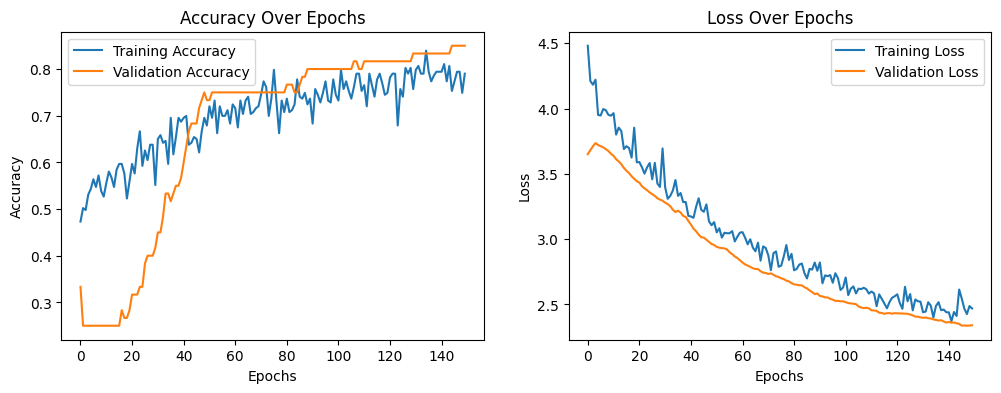

In [18]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model(best_model_path)


# Assuming `history` is the returned object from `model.fit()`
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



# Confusion Matrix


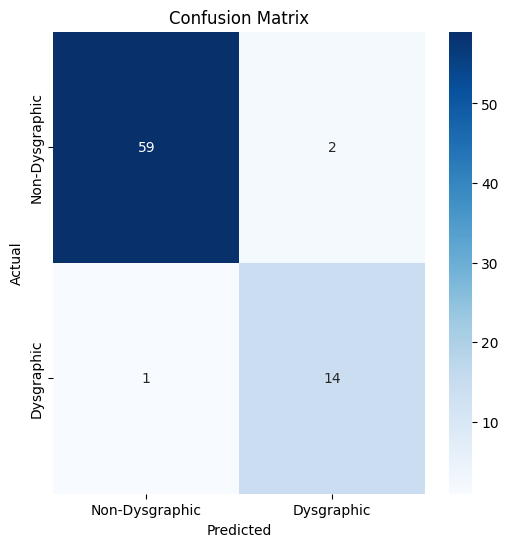

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


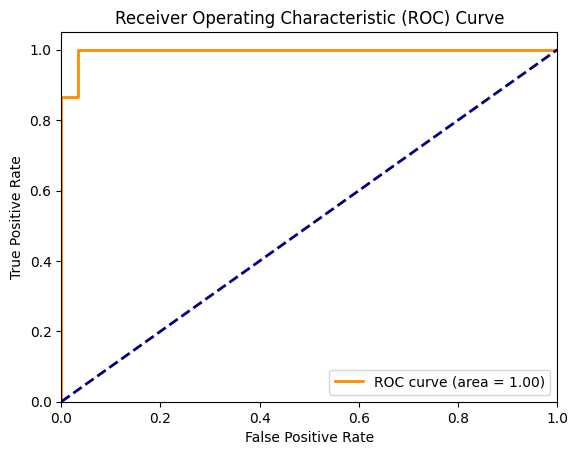

In [20]:
from sklearn.metrics import roc_curve, auc

# ROC Curve
fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


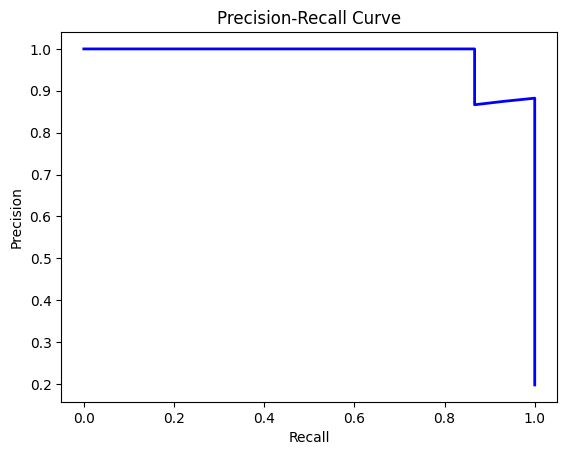

In [21]:
from sklearn.metrics import precision_recall_curve

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(true_labels, predictions)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


# RestNET

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import os

# Load the CSV file containing image paths and labels
data = pd.read_csv('/content/drive/MyDrive/Research_Dysgraphia/training_dataset.csv')

# Extract image paths and labels
image_paths = data['Image_Path'].values
labels = data['Label'].values

# Preprocess labels using one-hot encoding
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# Function to load and preprocess images
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Create data array for images
images = np.vstack([load_and_preprocess_image(img_path) for img_path in image_paths])

# Perform 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_val_labels = []
all_val_preds = []

for train_index, val_index in kf.split(images):
    print(f"Training fold {fold}...")
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]

    # Load pre-trained ResNet50 model + higher level layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = False  # Freeze the base model

    # Build the model on top of ResNet50
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(1, activation='sigmoid', dtype='float32')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model with a weighted loss function to handle class imbalance
    class_weights = {0: 1.0, 1: 3.0}
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Train the model with early stopping and learning rate scheduler
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

    history = model.fit(
        train_images, train_labels,
        validation_data=(val_images, val_labels),
        epochs=150,
        batch_size=16,
        verbose=1,
        class_weight=class_weights,
        callbacks=[early_stopping, lr_scheduler]
    )

    # Save the model for the current fold
    model.save(f'/content/drive/MyDrive/Research_Dysgraphia/New_ResNet50_model_fold_{fold}.h5')

    # Evaluate the model on the validation set
    val_preds = model.predict(val_images)
    val_preds_binary = (val_preds > 0.5).astype(int)

    # Calculate metrics for the current fold
    accuracy = accuracy_score(val_labels, val_preds_binary)
    precision = precision_score(val_labels, val_preds_binary)
    recall = recall_score(val_labels, val_preds_binary)
    f1 = f1_score(val_labels, val_preds_binary)

    print(f"Fold {fold} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Store validation labels and predictions for overall evaluation
    if fold == 5:
        print("\nClassification Report for Fold 5:")
        print(classification_report(val_labels, val_preds_binary))

    all_val_labels.extend(val_labels)
    all_val_preds.extend(val_preds_binary)

    fold += 1

# Final classification report and metrics after all folds
print("\nFinal Classification Report:")
print(classification_report(all_val_labels, all_val_preds))

# Save the final model
model.save('/content/drive/MyDrive/Research_Dysgraphia/New_ResNet50_final_model.h5')


Training fold 1...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 848ms/step - accuracy: 0.5921 - loss: 4.6189 - val_accuracy: 0.1967 - val_loss: 4.5342 - learning_rate: 5.0000e-05
Epoch 2/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.5920 - loss: 4.4911 - val_accuracy: 0.1967 - val_loss: 4.4188 - learning_rate: 5.0000e-05
Epoch 3/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5902 - loss: 4.4077 - val_accuracy: 0.2131 - val_loss: 4.3330 - learning_rate: 5.0000e-05
Epoch 4/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6682 - loss: 4.2729 - val_accuracy: 0.2787 - val_loss: 4.2358 - learning_rate: 5.0000e-05
Epoch 5/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6706 - loss: 4.2320 - val_accuracy: 0.5246 - val_loss: 4.1169 - learning_rate: 5.0000e-05
Epoch 6/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6430 - loss: 4.1970 - val_accuracy: 0.6557 - val_loss: 4.0273 - learning_rate: 5.

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step
Fold 1 - Accuracy: 0.9180, Precision: 0.8889, Recall: 0.6667, F1 Score: 0.7619
Training fold 2...
Epoch 1/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 620ms/step - accuracy: 0.5119 - loss: 4.9166 - val_accuracy: 0.8197 - val_loss: 4.1019 - learning_rate: 5.0000e-05
Epoch 2/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.5447 - loss: 4.6385 - val_accuracy: 0.7869 - val_loss: 4.0802 - learning_rate: 5.0000e-05
Epoch 3/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6448 - loss: 4.4152 - val_accuracy: 0.7213 - val_loss: 4.0754 - learning_rate: 5.0000e-05
Epoch 4/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5526 - loss: 4.5868 - val_accuracy: 0.6885 - val_loss: 4.0716 - learning_rate: 5.0000e-05
Epoch 5/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6323 - loss: 4.5355 - val_accuracy: 0.6885 - val_loss: 4.0663 - learning_rate: 5.0000e-05
Epoch 6/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5915 - loss: 4.556

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step
Fold 2 - Accuracy: 0.9508, Precision: 0.8333, Recall: 0.9091, F1 Score: 0.8696
Training fold 3...
Epoch 1/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 664ms/step - accuracy: 0.5980 - loss: 4.6329 - val_accuracy: 0.1475 - val_loss: 5.3183 - learning_rate: 5.0000e-05
Epoch 2/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.6080 - loss: 4.7184 - val_accuracy: 0.1475 - val_loss: 4.8785 - learning_rate: 5.0000e-05
Epoch 3/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5777 - loss: 4.6528 - val_accuracy: 0.2623 - val_loss: 4.5366 - learning_rate: 5.0000e-05
Epoch 4/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6854 - loss: 4.2924 - val_accuracy: 0.4918 - val_loss: 4.2726 - learning_rate: 5.0000e-05
Epoch 5/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6248 - loss: 4.4183 - val_accuracy: 0.6885 - val_loss: 4.0805 - learning_rate: 5.0000e-05
Epoch 6/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6940 - loss: 4.205

1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
Fold 3 - Accuracy: 0.9672, Precision: 0.8182, Recall: 1.0000, F1 Score: 0.9000
Training fold 4...
Epoch 1/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 810ms/step - accuracy: 0.4616 - loss: 5.1518 - val_accuracy: 0.3333 - val_loss: 4.2432 - learning_rate: 5.0000e-05
Epoch 2/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5253 - loss: 4.7270 - val_accuracy: 0.3000 - val_loss: 4.2582 - learning_rate: 5.0000e-05
Epoch 3/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5451 - loss: 4.6751 - val_accuracy: 0.2167 - val_loss: 4.2568 - learning_rate: 5.0000e-05
Epoch 4/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5955 - loss: 4.4764 - val_accuracy: 0.2667 - val_loss: 4.2405 - learning_rate: 5.0000e-05
Epoch 5/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6047 - loss: 4.4047 - val_accuracy: 0.3500 - val_loss: 4.1932 - learning_rate: 5.0000e-05
Epoch 6/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6028 - loss: 4.303

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step
Fold 4 - Accuracy: 0.9500, Precision: 0.9000, Recall: 0.8182, F1 Score: 0.8571
Training fold 5...
Epoch 1/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 668ms/step - accuracy: 0.4900 - loss: 4.7801 - val_accuracy: 0.7667 - val_loss: 4.1117 - learning_rate: 5.0000e-05
Epoch 2/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5205 - loss: 4.6745 - val_accuracy: 0.8167 - val_loss: 4.0784 - learning_rate: 5.0000e-05
Epoch 3/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6174 - loss: 4.4117 - val_accuracy: 0.8000 - val_loss: 4.0504 - learning_rate: 5.0000e-05
Epoch 4/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6183 - loss: 4.3829 - val_accuracy: 0.7833 - val_loss: 4.0338 - learning_rate: 5.0000e-05
Epoch 5/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5979 - loss: 4.2571 - val_accuracy: 0.7500 - val_loss: 4.0233 - learning_rate: 5.0000e-05
Epoch 6/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6450 - loss: 4.256

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


Fold 5 - Accuracy: 0.9167, Precision: 0.7778, Recall: 0.9333, F1 Score: 0.8485

Classification Report for Fold 5:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94        45
           1       0.78      0.93      0.85        15

    accuracy                           0.92        60
   macro avg       0.88      0.92      0.90        60
weighted avg       0.93      0.92      0.92        60


Final Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       245
           1       0.83      0.86      0.85        58

    accuracy                           0.94       303
   macro avg       0.90      0.91      0.91       303
weighted avg       0.94      0.94      0.94       303



In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

# Parameters
image_size = (128, 128)
batch_size = 8

# Load the testing dataset
testing_dataset_path = '/content/drive/MyDrive/Research_Dysgraphia/testing_dataset.csv'
test_df = pd.read_csv(testing_dataset_path)
test_df['Label'] = test_df['Label'].astype(str)

# Prepare the testing data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Image_Path",
    y_col="Label",
    target_size=image_size,
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False
)

# Load the best model
best_model_path = f'/content/drive/MyDrive/Research_Dysgraphia/New_ResNet50_model_fold_5.h5'
model = tf.keras.models.load_model(best_model_path)

# Evaluate the model on the testing dataset
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Testing Loss: {test_loss}")
print(f"Testing Accuracy: {test_accuracy}")

# Generate predictions
predictions = model.predict(test_generator)
predicted_labels = (predictions >= 0.5).astype(int).reshape(-1)

# True labels
true_labels = test_generator.classes

# Confusion Matrix and Classification Report
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

target_names = ['Non-Dysgraphic', 'Dysgraphic']
report = classification_report(true_labels, predicted_labels, target_names=target_names)
print("Classification Report:")
print(report)


Found 76 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 270ms/step - accuracy: 0.8221 - loss: 3.2743
Testing Loss: 3.3342134952545166
Testing Accuracy: 0.8026315569877625
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 304ms/step
Confusion Matrix:
[[61  0]
 [15  0]]
Classification Report:
                precision    recall  f1-score   support

Non-Dysgraphic       0.80      1.00      0.89        61
    Dysgraphic       0.00      0.00      0.00        15

      accuracy                           0.80        76
     macro avg       0.40      0.50      0.45        76
  weighted avg       0.64      0.80      0.71        76



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


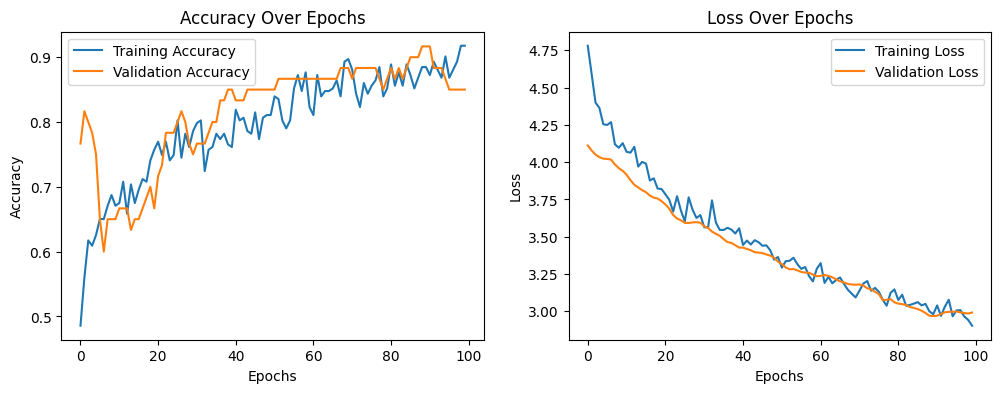

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model(best_model_path)


# Assuming `history` is the returned object from `model.fit()`
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



# CNN


Training fold 1...
Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 68s 5s/step - accuracy: 0.5595 - loss: 3.6767 - val_accuracy: 0.8033 - val_loss: 3.6628 - learning_rate: 5.0000e-05
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3750 - loss: 3.8630 - val_accuracy: 0.8033 - val_loss: 3.6620 - learning_rate: 5.0000e-05
Epoch 3/150


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 166ms/step - accuracy: 0.5485 - loss: 3.6685 - val_accuracy: 0.8033 - val_loss: 3.6556 - learning_rate: 5.0000e-05
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2222 - loss: 3.7710 - val_accuracy: 0.8033 - val_loss: 3.6549 - learning_rate: 5.0000e-05
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.5179 - loss: 3.6716 - val_accuracy: 0.1967 - val_loss: 3.6501 - learning_rate: 5.0000e-05
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6562 - loss: 3.4812 - val_accuracy: 0.1967 - val_loss: 3.6494 - learning_rate: 5.0000e-05
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.6160 - loss: 3.5587 - val_accuracy: 0.1967 - val_loss: 3.6419 - learning_rate: 5.0000e-05
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5312 - loss: 3.6474 - val_accuracy: 0.1967 - val_loss: 3.6414 - learning_rate: 5.0000e-05
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.5871 - loss: 3.5448

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1 - Accuracy: 0.8033, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000


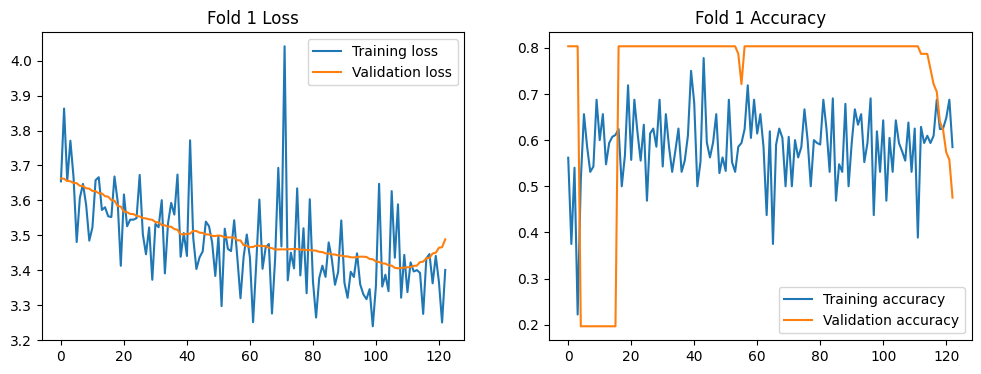


Training fold 2...
Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.3907 - loss: 3.7640 - val_accuracy: 0.8033 - val_loss: 3.6596 - learning_rate: 5.0000e-05
Epoch 2/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - accuracy: 0.4688 - loss: 3.7113

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4688 - loss: 3.7113 - val_accuracy: 0.8033 - val_loss: 3.6584 - learning_rate: 5.0000e-05
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.3489 - loss: 3.6948 - val_accuracy: 0.1967 - val_loss: 3.6520 - learning_rate: 5.0000e-05
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2500 - loss: 3.6230 - val_accuracy: 0.1967 - val_loss: 3.6509 - learning_rate: 5.0000e-05
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.4080 - loss: 3.6417 - val_accuracy: 0.1967 - val_loss: 3.6442 - learning_rate: 5.0000e-05
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5625 - loss: 3.6622 - val_accuracy: 0.1967 - val_loss: 3.6431 - learning_rate: 5.0000e-05
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.4474 - loss: 3.6506 - val_accuracy: 0.1967 - val_loss: 3.6373 - learning_rate: 5.0000e-05
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3438 - loss: 3.4745 -

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step   
Fold 2 - Accuracy: 0.7541, Precision: 0.2857, Recall: 0.1667, F1 Score: 0.2105


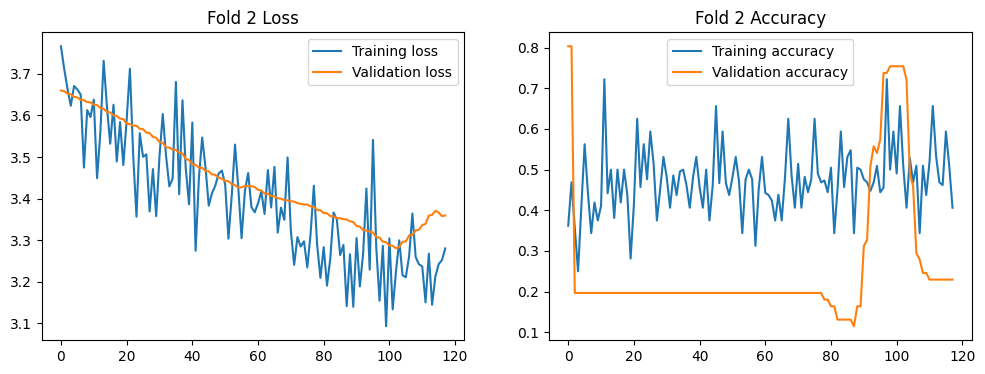


Training fold 3...
Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.4467 - loss: 3.7058 - val_accuracy: 0.8033 - val_loss: 3.6601 - learning_rate: 5.0000e-05
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5938 - loss: 3.5826 - val_accuracy: 0.8033 - val_loss: 3.6578 - learning_rate: 5.0000e-05
Epoch 3/150


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - accuracy: 0.4463 - loss: 3.6902 - val_accuracy: 0.8033 - val_loss: 3.6428 - learning_rate: 5.0000e-05
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3750 - loss: 3.7250 - val_accuracy: 0.8033 - val_loss: 3.6408 - learning_rate: 5.0000e-05
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.4636 - loss: 3.7047 - val_accuracy: 0.8033 - val_loss: 3.6288 - learning_rate: 5.0000e-05
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4375 - loss: 3.7326 - val_accuracy: 0.8033 - val_loss: 3.6268 - learning_rate: 5.0000e-05
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.5317 - loss: 3.6947 - val_accuracy: 0.8033 - val_loss: 3.6124 - learning_rate: 5.0000e-05
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4062 - loss: 3.6635 - val_accuracy: 0.8033 - val_loss: 3.6102 - learning_rate: 5.0000e-05
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.5137 - loss: 3.5483 

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
Fold 3 - Accuracy: 0.8361, Precision: 0.7500, Recall: 0.2500, F1 Score: 0.3750


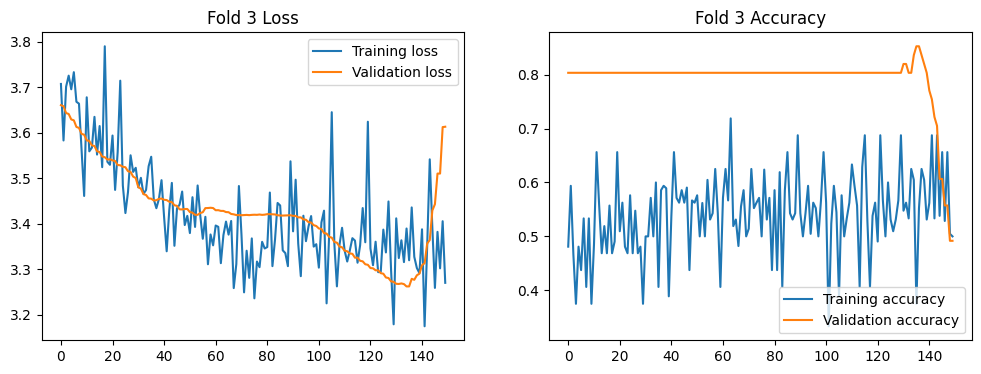


Training fold 4...
Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 52s 6s/step - accuracy: 0.5520 - loss: 3.7979 - val_accuracy: 0.1833 - val_loss: 3.6877 - learning_rate: 5.0000e-05
Epoch 2/150
1/7 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.6875 - loss: 3.6086

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6875 - loss: 3.6086 - val_accuracy: 0.1833 - val_loss: 3.6867 - learning_rate: 5.0000e-05
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - accuracy: 0.5581 - loss: 3.8481 - val_accuracy: 0.1833 - val_loss: 3.6835 - learning_rate: 5.0000e-05
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4688 - loss: 3.9423 - val_accuracy: 0.1833 - val_loss: 3.6832 - learning_rate: 5.0000e-05
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - accuracy: 0.6008 - loss: 3.8133 - val_accuracy: 0.1833 - val_loss: 3.6771 - learning_rate: 5.0000e-05
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5938 - loss: 3.5853 - val_accuracy: 0.1833 - val_loss: 3.6766 - learning_rate: 5.0000e-05
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.5564 - loss: 3.7978 - val_accuracy: 0.1833 - val_loss: 3.6720 - learning_rate: 5.0000e-05
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7188 - loss: 3.5168 -

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 4 - Accuracy: 0.8167, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000


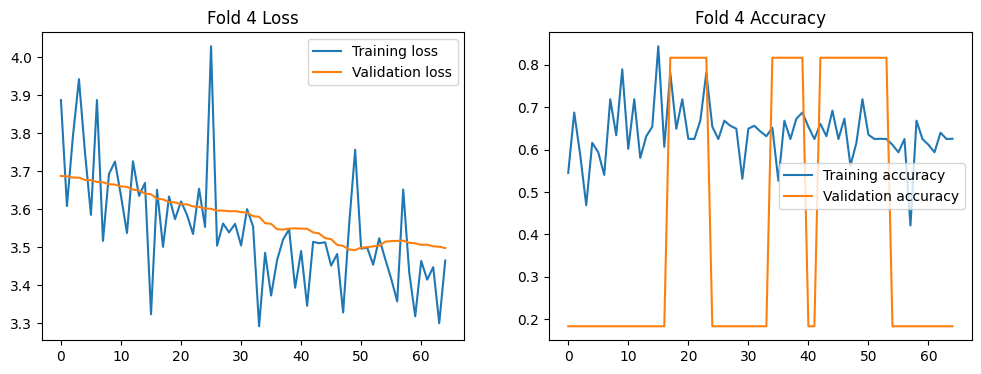


Training fold 5...
Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.4326 - loss: 3.7323 - val_accuracy: 0.1833 - val_loss: 3.6727 - learning_rate: 5.0000e-05
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5312 - loss: 3.6068 - val_accuracy: 0.1833 - val_loss: 3.6718 - learning_rate: 5.0000e-05
Epoch 3/150


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - accuracy: 0.4111 - loss: 3.6251 - val_accuracy: 0.1833 - val_loss: 3.6643 - learning_rate: 5.0000e-05
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5625 - loss: 3.5637 - val_accuracy: 0.1833 - val_loss: 3.6628 - learning_rate: 5.0000e-05
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.5134 - loss: 3.5848 - val_accuracy: 0.1833 - val_loss: 3.6556 - learning_rate: 5.0000e-05
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4375 - loss: 3.5102 - val_accuracy: 0.1833 - val_loss: 3.6544 - learning_rate: 5.0000e-05
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 0.4625 - loss: 3.6401 - val_accuracy: 0.8167 - val_loss: 3.6457 - learning_rate: 5.0000e-05
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5312 - loss: 3.5721 - val_accuracy: 0.8167 - val_loss: 3.6443 - learning_rate: 5.0000e-05
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.4686 - loss: 3.7746 

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
Fold 5 - Accuracy: 0.7833, Precision: 0.4286, Recall: 0.5455, F1 Score: 0.4800


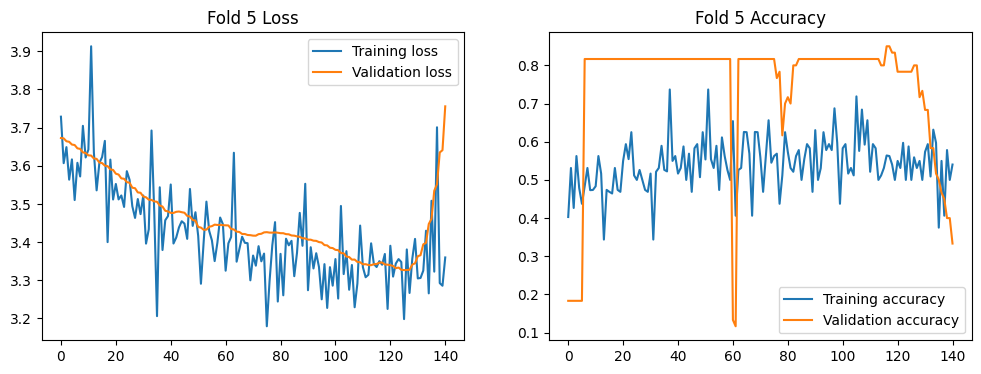


Final Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       245
           1       0.44      0.19      0.27        58

    accuracy                           0.80       303
   macro avg       0.64      0.57      0.57       303
weighted avg       0.76      0.80      0.77       303



In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense,
                                     BatchNormalization, Dropout, Add, Activation, GlobalAveragePooling2D)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import os

# Load the CSV file containing image paths and labels
data = pd.read_csv('/content/drive/MyDrive/Research_Dysgraphia/training_dataset.csv')

# Extract image paths and labels
image_paths = data['Image_Path'].values
labels = data['Label'].values

# Preprocess labels using LabelBinarizer
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# Function to load images
def load_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    return img_array

# Load images into an array
images = np.array([load_image(img_path) for img_path in image_paths])

# Normalize images
images = images / 255.0  # Normalize pixel values between 0 and 1

# Data Augmentation without rotation and mirroring
datagen = ImageDataGenerator(
    zoom_range=0.25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest"
)

# Function to plot training history
def plot_training_history(history, fold):
    # Plot loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.title(f'Fold {fold} Loss')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.legend()
    plt.title(f'Fold {fold} Accuracy')
    plt.show()

# Perform 5-fold cross-validation using StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_val_labels = []
all_val_preds = []

for train_index, val_index in kf.split(images, labels.flatten()):
    print(f"\nTraining fold {fold}...")
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]

    # Compute class weights dynamically
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels.flatten()),
        y=train_labels.flatten()
    )
    class_weights = dict(enumerate(class_weights))

    # Build a deeper custom CNN model with residual connections and Swish activation
    input_shape = (128, 128, 3)
    inputs = Input(shape=input_shape)

    # First Convolutional Block
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    shortcut = Conv2D(64, (1, 1), padding='same')(inputs)
    shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = Activation('swish')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Second Convolutional Block
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    shortcut = Conv2D(128, (1, 1), padding='same')(x)
    shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = Activation('swish')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Third Convolutional Block
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    shortcut = Conv2D(256, (1, 1), padding='same')(x)
    shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = Activation('swish')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Fourth Convolutional Block (Increased Capacity)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    shortcut = Conv2D(512, (1, 1), padding='same')(x)
    shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = Activation('swish')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Fully Connected Layers
    x = Dense(256, kernel_regularizer=l2(0.005))(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = Dropout(0.3)(x)  # Reduced Dropout Rate
    x = Dense(128, kernel_regularizer=l2(0.005))(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, kernel_regularizer=l2(0.005))(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid', dtype='float32')(x)

    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),  # Reduced Learning Rate
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Adjust early stopping and learning rate scheduler
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

    # Fit the model using data augmentation
    train_generator = datagen.flow(train_images, train_labels, batch_size=32)
    steps_per_epoch = len(train_images) // 32

    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        validation_data=(val_images, val_labels),
        epochs=150,
        verbose=1,
        class_weight=class_weights,
        callbacks=[early_stopping, lr_scheduler]
    )

    # Save the model for the current fold
    model.save(f'/content/drive/MyDrive/Research_Dysgraphia/Optimized_CustomCNN_model_fold_{fold}.h5')

    # Evaluate the model on the validation set
    val_preds = model.predict(val_images)
    val_preds_binary = (val_preds > 0.5).astype(int)

    # Calculate metrics for the current fold
    accuracy = accuracy_score(val_labels, val_preds_binary)
    precision = precision_score(val_labels, val_preds_binary)
    recall = recall_score(val_labels, val_preds_binary)
    f1 = f1_score(val_labels, val_preds_binary)

    print(f"Fold {fold} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, "
          f"Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Plot training history
    plot_training_history(history, fold)

    # Store validation labels and predictions for overall evaluation
    all_val_labels.extend(val_labels)
    all_val_preds.extend(val_preds_binary)

    fold += 1

# Final classification report and metrics after all folds
print("\nFinal Classification Report:")
print(classification_report(all_val_labels, all_val_preds))

# Save the final model
model.save('/content/drive/MyDrive/Research_Dysgraphia/Optimized_CustomCNN_final_model.h5')


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

# Parameters
image_size = (128, 128)
batch_size = 8

# Load the testing dataset
testing_dataset_path = '/content/drive/MyDrive/Research_Dysgraphia/testing_dataset.csv'
test_df = pd.read_csv(testing_dataset_path)
test_df['Label'] = test_df['Label'].astype(str)

# Prepare the testing data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Image_Path",
    y_col="Label",
    target_size=image_size,
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False
)

# Load the best model
best_model_path = f'/content/drive/MyDrive/Research_Dysgraphia/Optimized_CustomCNN_model_fold_3.h5'
model = tf.keras.models.load_model(best_model_path)

# Evaluate the model on the testing dataset
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Testing Loss: {test_loss}")
print(f"Testing Accuracy: {test_accuracy}")

# Generate predictions
predictions = model.predict(test_generator)
predicted_labels = (predictions >= 0.5).astype(int).reshape(-1)

# True labels
true_labels = test_generator.classes

# Confusion Matrix and Classification Report
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

target_names = ['Non-Dysgraphic', 'Dysgraphic']
report = classification_report(true_labels, predicted_labels, target_names=target_names)
print("Classification Report:")
print(report)


Found 76 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.7920 - loss: 3.3033
Testing Loss: 3.305826425552368
Testing Accuracy: 0.7894737124443054
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step
Confusion Matrix:
[[57  4]
 [12  3]]
Classification Report:
                precision    recall  f1-score   support

Non-Dysgraphic       0.83      0.93      0.88        61
    Dysgraphic       0.43      0.20      0.27        15

      accuracy                           0.79        76
     macro avg       0.63      0.57      0.57        76
  weighted avg       0.75      0.79      0.76        76



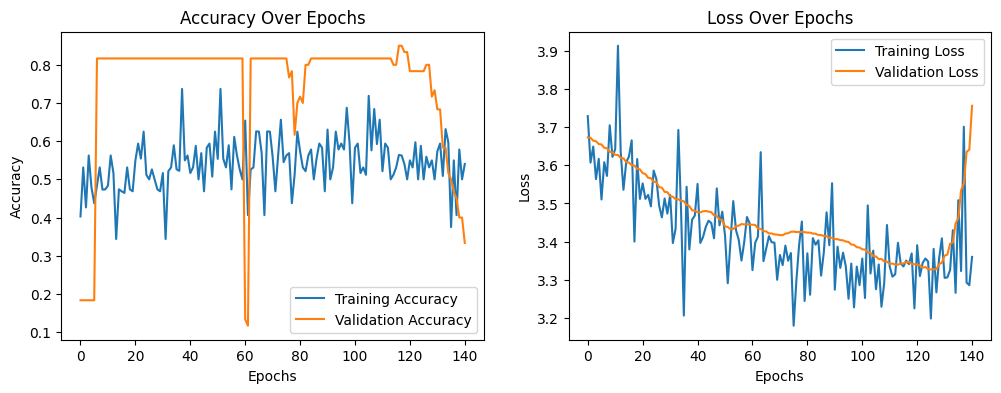

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model(best_model_path)


# Assuming `history` is the returned object from `model.fit()`
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

